# Titanic prediction using Logistic Regression

## Import data & visualization 

In [1]:
from fastai.imports import *
from fastai.structured import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from IPython.display import display

from sklearn import metrics
import datetime

C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
PATH = "data/titanic/"

In [3]:
os.listdir(PATH)

['gender_submission.csv', 'test.csv', 'train.csv']

In [4]:
train = pd.read_csv(f'{PATH}train.csv')
test = pd.read_csv(f'{PATH}test.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.shape, test.shape

((891, 12), (418, 11))

In [7]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

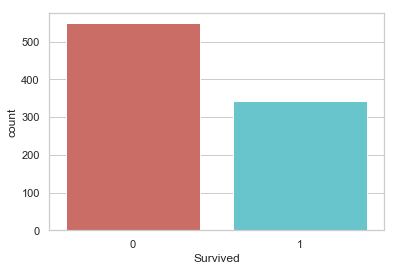

In [9]:
sns.countplot(x='Survived', data=train, palette='hls')
plt.show()

In [10]:
train.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


Text(0, 0.5, 'Survived')

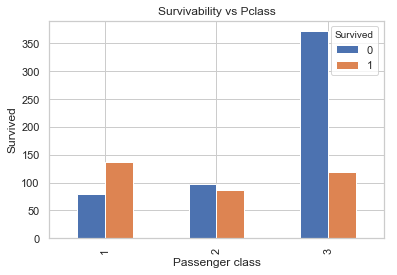

In [15]:
%matplotlib inline
pd.crosstab(train.Pclass,train.Survived).plot(kind='bar')
plt.title('Survivability vs Pclass')
plt.xlabel('Passenger class')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

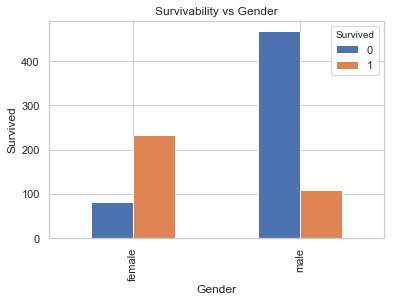

In [17]:
pd.crosstab(train.Sex, train.Survived).plot(kind='bar')
plt.title('Survivability vs Gender')
plt.xlabel('Gender')
plt.ylabel('Survived')

In [30]:
x.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,...,IsAlone,Title,Has_Cabin,Sex_female,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,3,109,1,1,0,524,0,0,2,...,0,1,1,0,1,0,0,0,1,0
1,2,1,191,2,1,0,597,3,82,2,...,0,3,1,1,0,0,1,0,0,0
2,3,3,354,1,0,0,670,1,0,1,...,1,2,1,1,0,0,0,0,1,0
3,4,1,273,2,1,0,50,3,56,2,...,0,3,1,1,0,0,0,0,1,0
4,5,3,16,2,0,0,473,1,0,1,...,1,1,1,0,1,0,0,0,1,0


Text(0, 0.5, 'Survived')

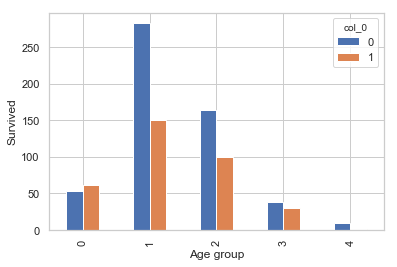

In [31]:
pd.crosstab(x.Age, y).plot(kind='bar')
plt.xlabel('Age group')
plt.ylabel('Survived')

## Process data

In [14]:
# Change any columns of strings in a panda's dataframe to a column of
#     catagorical values. This applies the changes inplace.

In [18]:
train_cats(train)
train_cats(test)

In [19]:
data = [train, test]

In [20]:
# add FamilySize
for df in data:
    df['FamilySize']=df['SibSp']+df['Parch']+1

In [21]:
for df in data:
    age_avg = df['Age'].mean()
    age_std = df['Age'].std()
    age_null_count = df['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    df['Age'][np.isnan(df['Age'])] = age_null_random_list
    df['Age'] = df['Age'].astype(int)

C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
# add Fare per person
for df in data:
    df['Fare_Per_Person']=df['Fare']/(df['FamilySize'])
    df['Age*Class']=df['Age']*df['Pclass']

In [23]:
for df in data:
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

In [24]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [25]:
for df in data:
    df['Title'] = df['Name'].apply(get_title)

In [26]:
for df in data:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [27]:
for df in data:
    df['Fare'] = df['Fare'].fillna(train['Fare'].median())
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna(0)
    
    # Mapping Fare
    df.loc[ df['Fare'] <= 7.91, 'Fare'] 						        = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df.loc[ df['Fare'] > 31, 'Fare'] 							        = 3
    df['Fare'] = df['Fare'].astype(int)
    
    # Mapping Age
    df.loc[ df['Age'] <= 16, 'Age'] 					       = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[ df['Age'] > 64, 'Age'] = 4 ;

In [28]:
for df in data:
    df['Has_Cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [29]:
x,y,nas = proc_df(train, 'Survived', max_n_cat=6)
x_test, _, nas = proc_df(test, max_n_cat=6)

In [ ]:
cols = [c for c in x_test.columns if c not in x.columns]; cols

In [ ]:
x_test = x_test.drop(cols, axis=1)

In [ ]:
to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']

In [ ]:
x_test = x_test.drop(to_drop, axis=1)
x = x.drop(to_drop, axis=1)

In [ ]:
x.head(), x.shape

In [ ]:
x_test.head(), x.shape

In [ ]:
m = LogisticRegression()

In [ ]:
m.fit(x, y)

In [ ]:
# prediction
predicted = m.predict(x_test)

In [ ]:
my_submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predicted})

In [ ]:
my_submission[my_submission.Survived==0].count()

In [ ]:
my_submission.to_csv('titanic_submission.csv', index=False)

The submission got a score of 0.77990 on the test set.

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(m, 8)
rfe = rfe.fit(x, y)
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
cols = ['Pclass', 'Age', 'SibSp', 'Title', 'Has_Cabin', 'Sex_female', 'Sex_male', 'Embarked_C']

In [ ]:
x_reduced = x[cols]; x_test_reduced = x_test[cols]

In [ ]:
m2 = LogisticRegression()
m2.fit(x_reduced, y)

In [ ]:
# prediction #2
predicted = m2.predict(x_test_reduced)
my_submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predicted})
my_submission.to_csv('titanic_submission.csv', index=False)

This submission got a score of 0.77511